# Water Management Model Notebook
This notebook demonstrates a machine learning model to predict water usage and control motors based on forecasted needs.

## Importing Required Libraries

In [40]:
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

## Load Data Function

In [41]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path)

## Create Sequences Function

In [42]:
def create_sequences(data, time_steps=24):
    sequences, targets = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        targets.append(data[i + time_steps])
    return np.array(sequences), np.array(targets)

## Build CNN Model Function

In [43]:
def build_cnn_model(input_shape):
    """Build a 1D CNN model for water usage prediction."""
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train CNN Model Function

In [44]:
def train_cnn_model(X_train, y_train, X_test, y_test):
    cnn_model = build_cnn_model((X_train.shape[1], 1))
    history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    return cnn_model, history

## Train Other Models Function

In [45]:
def train_other_models(X_train, y_train):
    # Reshape X_train to 2D for compatibility with the other models
    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
    
    rf_model = RandomForestRegressor(n_estimators=100).fit(X_train_2d, y_train)
    xgb_model = XGBRegressor(n_estimators=100).fit(X_train_2d, y_train)
    
    return rf_model, xgb_model

## Ensemble Predictions Function

In [46]:
def ensemble_predictions(cnn_model, rf_model, xgb_model, X_test):
    cnn_preds = cnn_model.predict(X_test).flatten()
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    return np.column_stack((cnn_preds, rf_preds, xgb_preds))

## Final Model Training Function

In [47]:
def train_final_model(stacked_features, y_test):
    final_model = LinearRegression().fit(stacked_features, y_test)
    return final_model

## Model Evaluation Function

In [48]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return mse, mae

In [49]:
def plot_training_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN Model Training Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
# Enhanced plot_data function with markers and gridlines
def plot_data(data):
    plt.figure(figsize=(14, 7))
    
    # Plotting the water usage data
    plt.plot(data['timestamp'], data['water_usage'], 
             label='Water Usage (%)', 
             color='blue', 
             marker='o', 
             linestyle='-', 
             markersize=4)
    
    # Setting the labels and title
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Water Usage (%)', fontsize=14)
    plt.title('Water Usage Over Time', fontsize=16)
    
    # Enhancing grid visibility
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Formatting the x-axis for better date representation
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adding a legend
    plt.legend(fontsize=12, loc='upper left')
    
    # Adding a tight layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()



In [51]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Water Usage', color='blue')
    plt.plot(y_pred, label='Predicted Water Usage', color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Water Usage (%)')
    plt.title('Actual vs. Predicted Water Usage')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Main Execution

In [52]:
def main():
    # Load and prepare data
    data = load_data('dataset.csv')
    if 'water_usage' not in data.columns:
        raise ValueError("The dataset must contain a 'water_usage' column.")
    
    sequences, targets = create_sequences(data['water_usage'].values)
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Train individual models
    cnn_model, history = train_cnn_model(X_train, y_train, X_test, y_test)
    rf_model, xgb_model = train_other_models(X_train, y_train)
    
    # Get predictions
    cnn_preds = cnn_model.predict(X_test).flatten()
    rf_preds = rf_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))
    xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))
    
    # Evaluate individual models
    evaluate_model('CNN', y_test, cnn_preds)
    evaluate_model('Random Forest', y_test, rf_preds)
    evaluate_model('XGBoost', y_test, xgb_preds)
    
    # Ensemble predictions
    stacked_features = np.column_stack((cnn_preds, rf_preds, xgb_preds))
    final_model = train_final_model(stacked_features, y_test)
    ensemble_preds = final_model.predict(stacked_features)
    
    # Evaluate ensemble
    evaluate_model('Ensemble', y_test, ensemble_preds)
    
    plot_training_loss(history)
    plot_data(data)
    plot_predictions(y_test, ensemble_preds)

    # Plot predictions
    plt.plot(y_test, label='True')
    plt.plot(ensemble_preds, label='Ensemble Predictions')
    plt.legend()
    plt.title('Ensemble Predictions vs True Values')
    plt.show()

### Execute Main Function

Epoch 1/50


c:\Projects\Water-consumption-Analysis\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 148.1486 - val_loss: 9.1754
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.7303 - val_loss: 9.3953
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.4937 - val_loss: 11.0708
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.7632 - val_loss: 9.3337
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.6585 - val_loss: 9.2184
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.8810 - val_loss: 9.1918
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.0879 - val_loss: 9.6450
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5612 - val_loss: 9.5573
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1372 - val_loss: 11.6257
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.5980 - val_loss: 9.1950
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.5384 - val_loss: 9.8315
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

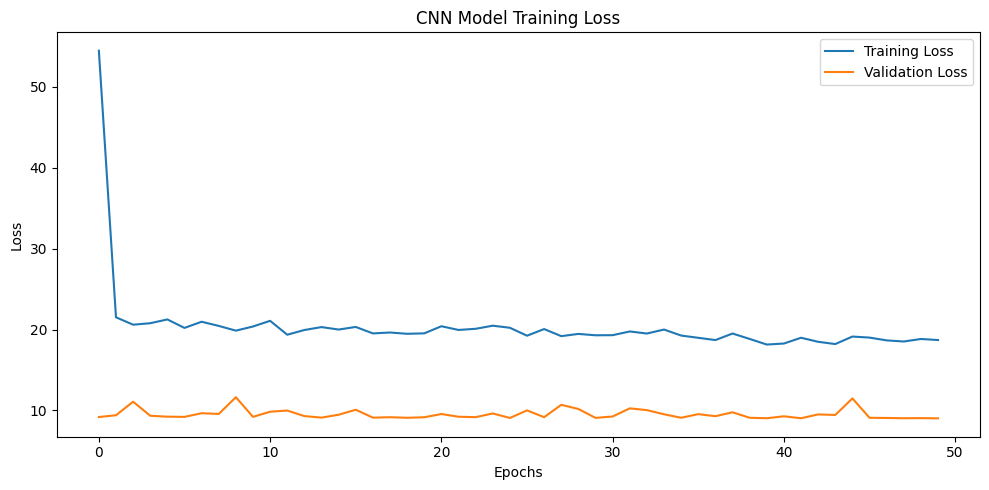

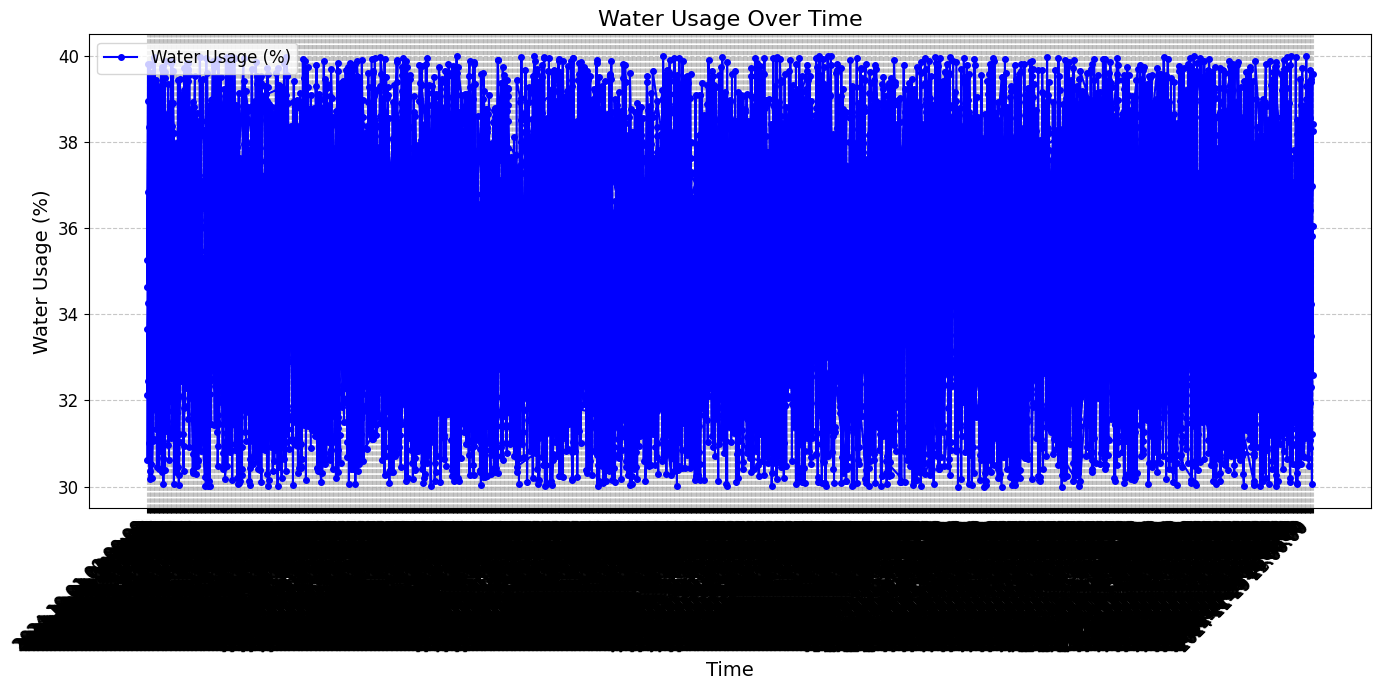

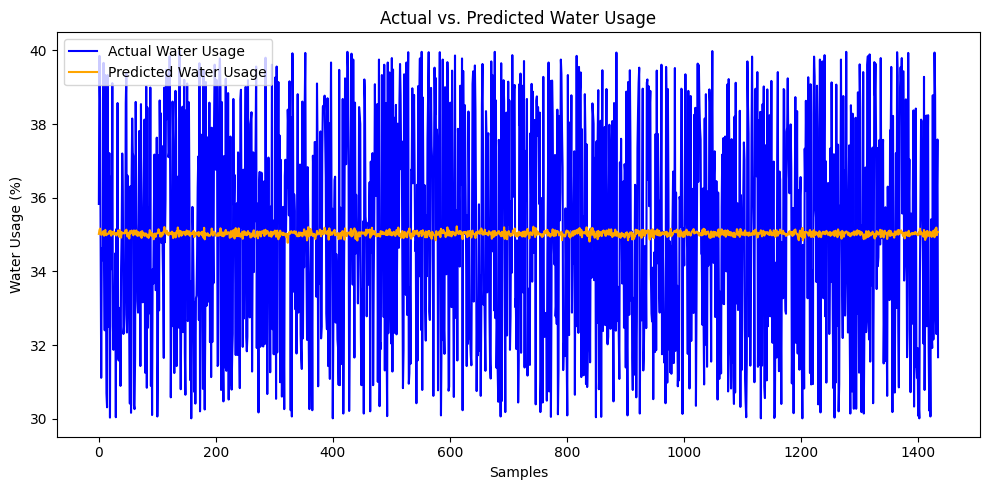

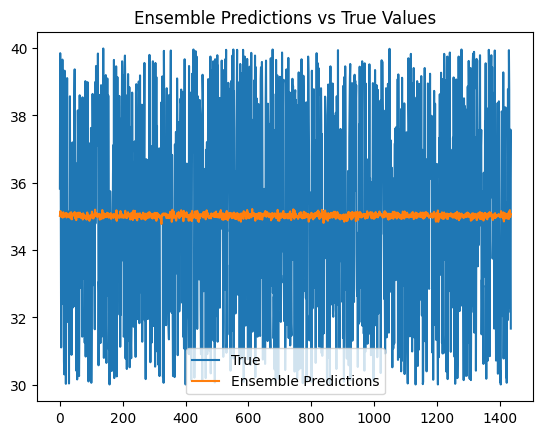

In [53]:
main()